In [1]:
import os
import sys

import xarray as xr
import numpy as np
import zarr

import pandas as pd

import s3fs
import gcsfs
import boto3

from shapely import geometry

import matplotlib
import matplotlib.pyplot as plt

import itertools
from functools import partial

from dask.distributed import Client

import cartopy.crs as ccrs
import cartopy.feature as cf

GCP_PROJECT_ID = '170771369993'
OISST_GCP = 'oisst/oisst.zarr'

%matplotlib inline

In [2]:
dask_client = Client()
dask_client

Client Scheduler: tcp://127.0.0.1:36997 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 33.45 GB


# Compute TPC/MHW interactions regionally


This notebook investigates the following: 

* Sanity-checks for MHW detections
* Sanity-checks for TPC computation regionally
* Patterns of performance generally over time 
* Patterns of performance as they differ from climatologically-derived performance


In [3]:
# Load SST
fs = gcsfs.GCSFileSystem(project=GCP_PROJECT_ID, token="../gc-pangeo.json")
oisst = xr.open_zarr(fs.get_mapper(OISST_GCP))
oisst = oisst.assign_coords(lon=(((oisst.lon + 180) % 360) - 180)).sortby('lon')
# Slice to PNW
PNW_LAT = slice(30, 60)
PNW_LON = slice(-155.9, -120.9)
oisst_pnw = oisst.sel(lat = PNW_LAT, lon = PNW_LON).compute()
# Load MHWs
awsfs = s3fs.S3FileSystem()
mhw_mapper = s3fs.S3Map("s3://mhw-stress/new_with_climatology", s3=awsfs)
mhws = xr.open_zarr(mhw_mapper, consolidated=True)

In [4]:
mhws = xr.open_zarr(mhw_mapper, consolidated=True)
mhws = mhws.chunk({
    'lat': 100, 
    'lon' : 100, 
    'time': 500
})

In [5]:
mhws.lon

<xarray.DataArray 'lon' (lon: 140)>
array([-155.875, -155.625, -155.375, -155.125, -154.875, -154.625, -154.375,
       -154.125, -153.875, -153.625, -153.375, -153.125, -152.875, -152.625,
       -152.375, -152.125, -151.875, -151.625, -151.375, -151.125, -150.875,
       -150.625, -150.375, -150.125, -149.875, -149.625, -149.375, -149.125,
       -148.875, -148.625, -148.375, -148.125, -147.875, -147.625, -147.375,
       -147.125, -146.875, -146.625, -146.375, -146.125, -145.875, -145.625,
       -145.375, -145.125, -144.875, -144.625, -144.375, -144.125, -143.875,
       -143.625, -143.375, -143.125, -142.875, -142.625, -142.375, -142.125,
       -141.875, -141.625, -141.375, -141.125, -140.875, -140.625, -140.375,
       -140.125, -139.875, -139.625, -139.375, -139.125, -138.875, -138.625,
       -138.375, -138.125, -137.875, -137.625, -137.375, -137.125, -136.875,
       -136.625, -136.375, -136.125, -135.875, -135.625, -135.375, -135.125,
       -134.875, -134.625, -134.375, -134.125, -133.875, -133.625, -133.375,
       -133.125, -132.875, -132.625, -132.375, -132.125, -131.875, -131.625,
       -131.375, -131.125, -130.875, -130.625, -130.375, -130.125, -129.875,
       -129.625, -129.375, -129.125, -128.875, -128.625, -128.375, -128.125,
       -127.875, -127.625, -127.375, -127.125, -126.875, -126.625, -126.375,
       -126.125, -125.875, -125.625, -125.375, -125.125, -124.875, -124.625,
       -124.375, -124.125, -123.875, -123.625, -123.375, -123.125, -122.875,
       -122.625, -122.375, -122.125, -121.875, -121.625, -121.375, -121.125])
Coordinates:
  * lon      (lon) float64 -155.9 -155.6 -155.4 -155.1 ... -121.6 -121.4 -121.1

In [6]:
oisst_pnw.lon

<xarray.DataArray 'lon' (lon: 140)>
array([-155.875, -155.625, -155.375, -155.125, -154.875, -154.625, -154.375,
       -154.125, -153.875, -153.625, -153.375, -153.125, -152.875, -152.625,
       -152.375, -152.125, -151.875, -151.625, -151.375, -151.125, -150.875,
       -150.625, -150.375, -150.125, -149.875, -149.625, -149.375, -149.125,
       -148.875, -148.625, -148.375, -148.125, -147.875, -147.625, -147.375,
       -147.125, -146.875, -146.625, -146.375, -146.125, -145.875, -145.625,
       -145.375, -145.125, -144.875, -144.625, -144.375, -144.125, -143.875,
       -143.625, -143.375, -143.125, -142.875, -142.625, -142.375, -142.125,
       -141.875, -141.625, -141.375, -141.125, -140.875, -140.625, -140.375,
       -140.125, -139.875, -139.625, -139.375, -139.125, -138.875, -138.625,
       -138.375, -138.125, -137.875, -137.625, -137.375, -137.125, -136.875,
       -136.625, -136.375, -136.125, -135.875, -135.625, -135.375, -135.125,
       -134.875, -134.625, -134.375, -134.125, -133.875, -133.625, -133.375,
       -133.125, -132.875, -132.625, -132.375, -132.125, -131.875, -131.625,
       -131.375, -131.125, -130.875, -130.625, -130.375, -130.125, -129.875,
       -129.625, -129.375, -129.125, -128.875, -128.625, -128.375, -128.125,
       -127.875, -127.625, -127.375, -127.125, -126.875, -126.625, -126.375,
       -126.125, -125.875, -125.625, -125.375, -125.125, -124.875, -124.625,
       -124.375, -124.125, -123.875, -123.625, -123.375, -123.125, -122.875,
       -122.625, -122.375, -122.125, -121.875, -121.625, -121.375, -121.125],
      dtype=float32)
Coordinates:
  * lon      (lon) float32 -155.875 -155.625 -155.375 ... -121.375 -121.125

In [5]:
mhws.mhw.data

,Array,Chunk
Bytes,1.83 GB,40.00 MB
Shape,"(120, 140, 13636)","(100, 100, 500)"
Count,871 Tasks,112 Chunks
Type,float64,numpy.ndarray


In [6]:
CENTRAL_LONGITUDE = ((mhws.lon.max() + mhws.lon.min()) / 2).values
CENTRAL_LATITUDE = ((mhws.lat.max() + mhws.lat.min()) / 2).values
PLOT_MAP_PROJECTION = ccrs.Stereographic(central_longitude=CENTRAL_LONGITUDE)

## MHW Detections Sanity Checks

First a plot of all detections per pixel -- shows detection hotspots.  

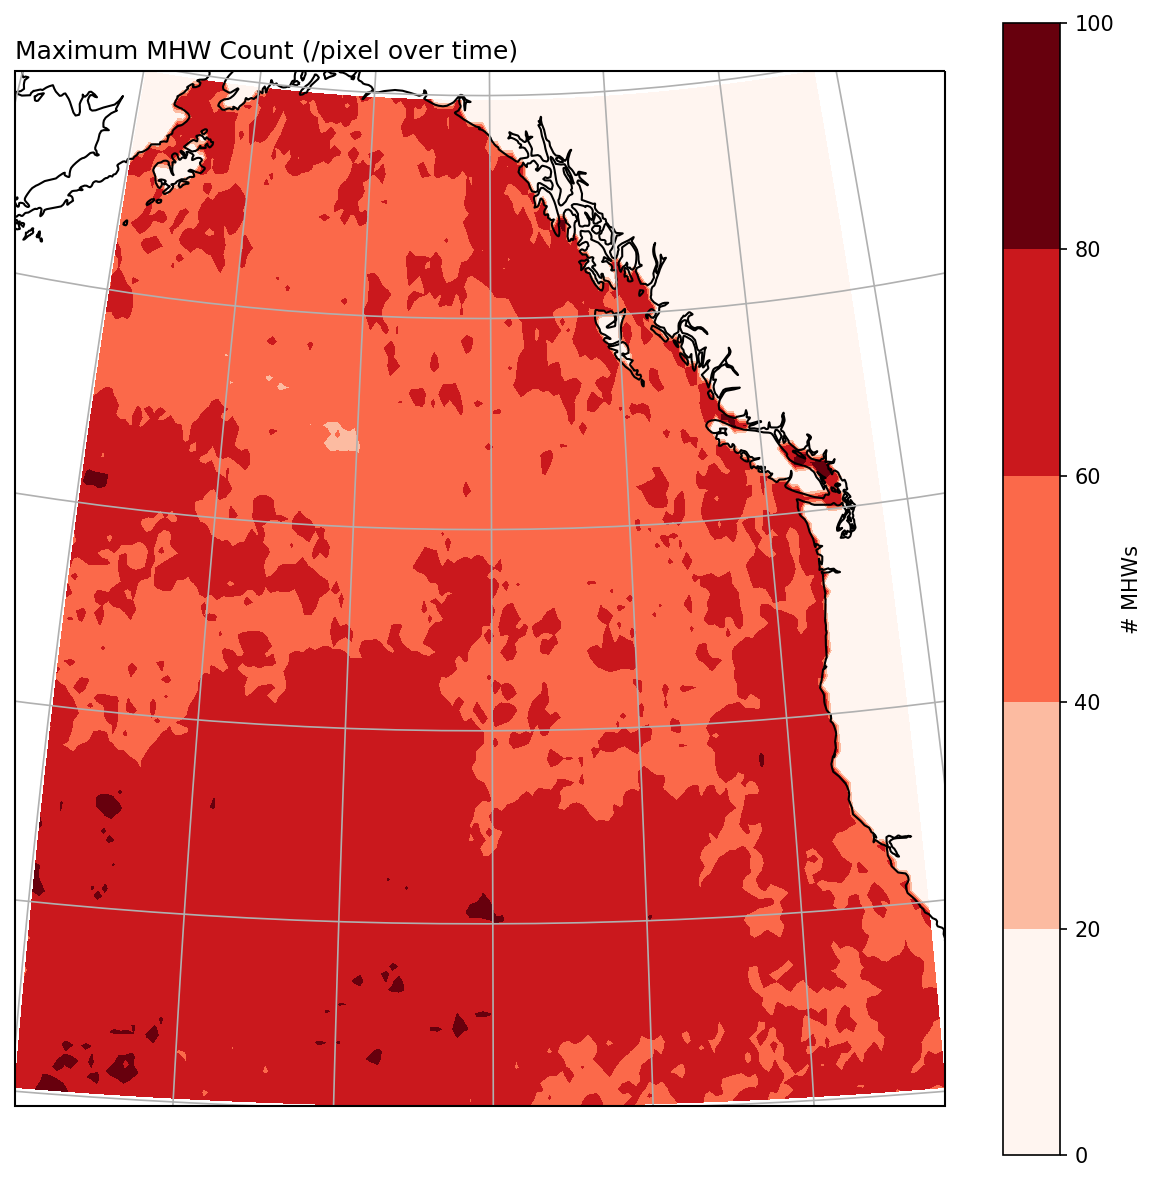

In [7]:
fig = plt.figure(figsize=(10,10), dpi=150)
ax = plt.axes(projection=PLOT_MAP_PROJECTION)
mhws.mhw.max(dim='time').plot.contourf(
    ax=ax, transform=ccrs.PlateCarree(),
    cbar_kwargs={'label' : "# MHWs"},
    cmap=plt.cm.Reds
)
ax.add_feature(cf.NaturalEarthFeature('physical', 'coastline', '50m'), facecolor='none', edgecolor='k')
ax.set_title("Maximum MHW Count (/pixel over time)", loc='left')
ax.gridlines()

Next a plot of MHWs each year from **1990-2018** per pixel. 

In [8]:
masked = mhws.where(mhws.mhw !=0, drop=True).sel(time=slice('1990', '2018')).mhw.groupby('time.year').count(dim='time')

In [10]:
masked.data

,Array,Chunk
Bytes,3.90 MB,80.00 kB
Shape,"(120, 140, 29)","(100, 100, 1)"
Count,2555 Tasks,116 Chunks
Type,int64,numpy.ndarray


In [11]:
a = masked.compute()

In [13]:
extent = [
    oisst_pnw.lon.min().values,
    oisst_pnw.lon.max().values,
    oisst_pnw.lat.min().values,
    oisst_pnw.lat.max().values

]

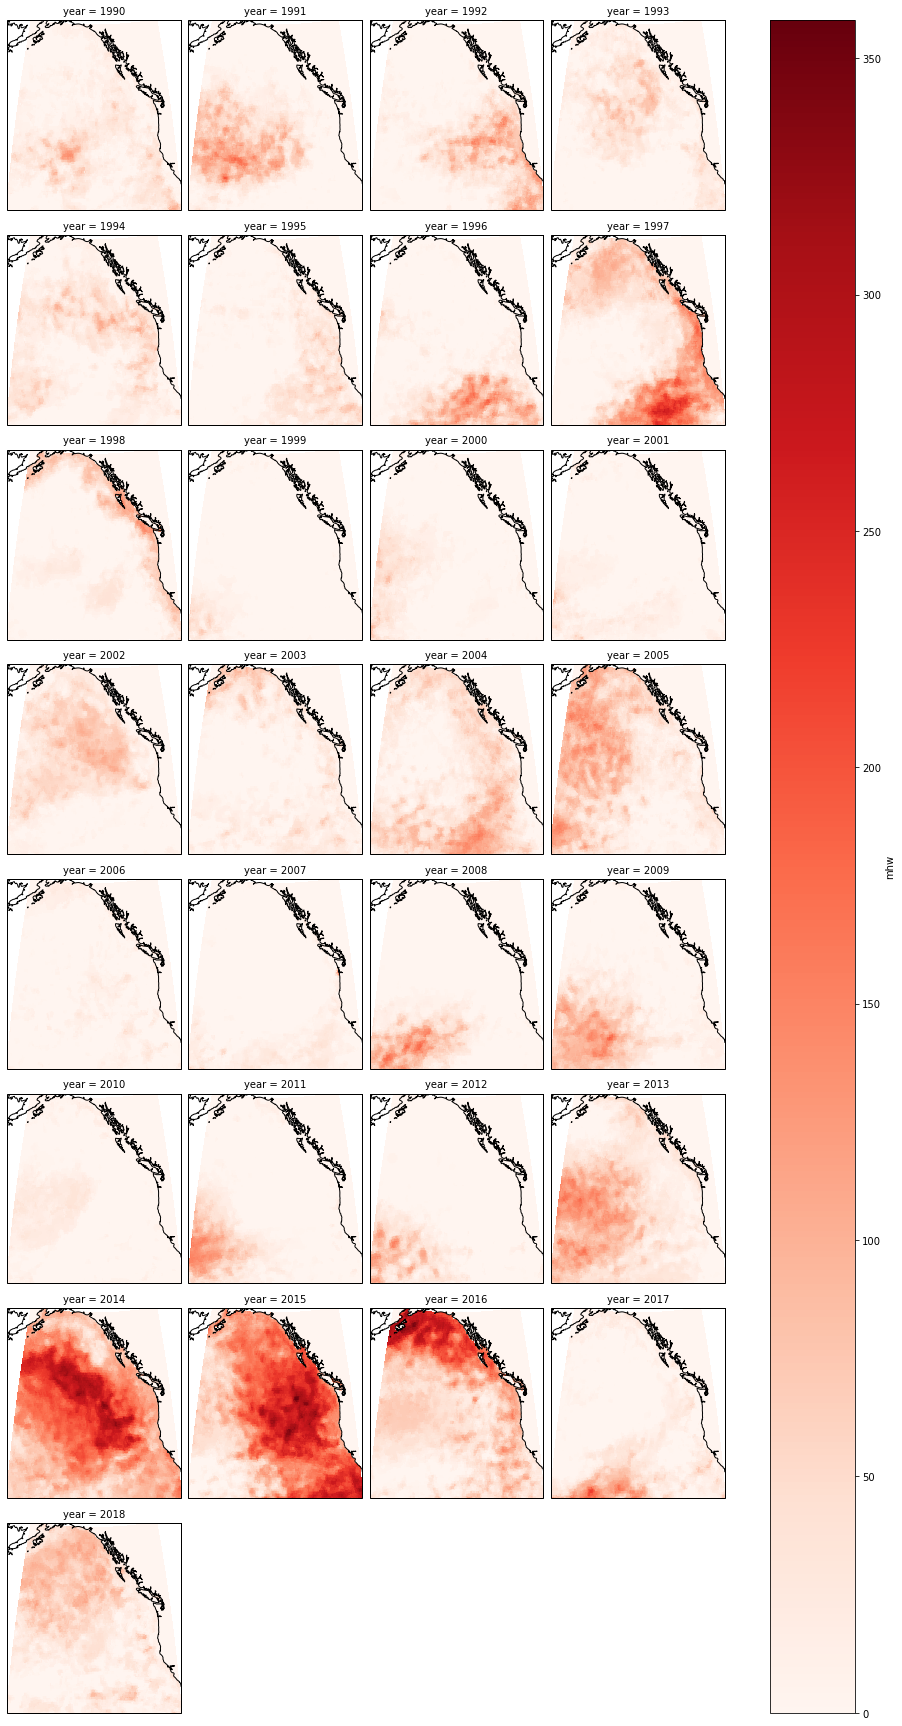

In [14]:
fg = a.plot.pcolormesh(col='year', col_wrap = 4, transform=ccrs.PlateCarree(), cmap='Reds', subplot_kws={'projection': PLOT_MAP_PROJECTION})

list(map(lambda x: x.set_extent(extent), fg.axes.ravel()))
list(map(lambda x: x.add_feature(cf.NaturalEarthFeature('physical', 'coastline', '50m'), facecolor='none', edgecolor='k'), fg.axes.ravel()))
plt.show()

## Thermal Performance Curve Assessments 

First load and select data. 

In [10]:
sys.path.append('../analysis/physiology/')
import tpc

In [11]:
plankton = pd.read_csv('../data/Phytoplankton_temperature_growth_rate_dataset_2016_01_29/traits_derived_2016_01_29.csv', engine='python')

In [12]:
plankton = plankton[
    (plankton.curvequal == 'good') &
    (plankton.habitat.isin([
        'marine',
    ]))
]
len(plankton)

96

Divide these data into latitudinal bins and select those within a latitudinal bin near the study region

In [13]:
plankton['latqbin'] = pd.cut(plankton['isolation.latitude'], bins=20)
plankton = plankton[plankton.latqbin.isin([mhws.lat.values.max()])]

In [14]:
plankton

,isolate.code,source,isolation.latitude,isolation.longitude,habitat,name,speciesname,former.name.1,former.name.2,strain,...,maxqual,curvequal,abs.curveskew,rel.curveskew,used.for.optimum.analysis,used.for.tmax.analysis,used.for.tmin.analysis,used.for.niche.width.analysis,used.for.max.growth.rate.analysis,latqbin
212,299,"B�sum harbour, Wadden Sea, Germany",54.12,8.86,marine,Fibrocapsa japonica strain CCRuG-C13,Fibrocapsa japonica,NaN,NaN,CCRuG-C13,...,good,good,-132.809926,-0.010578,1.0,1.0,1.0,1.0,1.0,"(53.614, 61.169]"
230,324,Northern Baltic,58.88,20.32,marine,Gymnodinium corollarium clone GCTV-B4,Gymnodinium corollarium,NaN,NaN,GCTV-B4,...,good,good,25.149152,0.012772,1.0,1.0,1.0,1.0,1.0,"(53.614, 61.169]"
456,603,"Hordaland, Norway",60.17,5.54,marine,Nannochloropsis oceanica strain CCAP 849/10,Nannochloris oceanica,NaN,NaN,CCAP 849/10,...,good,good,-226.648610,-0.014912,1.0,1.0,1.0,1.0,1.0,"(53.614, 61.169]"


Choose one randomly. 

In [18]:
sample = plankton.sample(1).iloc[0]

sample

isolate.code                                                          299
source                                 B�sum harbour, Wadden Sea, Germany
isolation.latitude                                                  54.12
isolation.longitude                                                  8.86
habitat                                                            marine
name                                 Fibrocapsa japonica strain CCRuG-C13
speciesname                                           Fibrocapsa japonica
former.name.1                                                         NaN
former.name.2                                                         NaN
strain                                                          CCRuG-C13
clone                                                                 NaN
species                                                          japonica
genus                                                          Fibrocapsa
family                                

Develop TPC for this species and create `ufunc`. 

In [19]:
tpc_f = partial(tpc.tpc, a=sample['mu.alist'], b=sample['mu.blist'], z=sample['mu.c.opt.list'], w=sample['mu.wlist'])

In [20]:
def tpc_1d(temps):
#     if(np.isnan(temps).any()): return np.full_like(temps, fill_value=np.nan)
    nanmasked =  np.ma.array(temps, mask=np.isnan(temps))
    return(tpc_f(nanmasked))
    


In [96]:
tpc_compute = xr.apply_ufunc(
    tpc_1d,
    oisst_pnw.sst.chunk({'lat': 5, 'lon': 5, 'time': -1}),
    input_core_dims=[['time']],
    output_core_dims = [['time']],
    dask='parallelized', 
    output_dtypes=['float64'],
    vectorize=True
)

In [97]:
tpc_compute

,Array,Chunk
Bytes,1.83 GB,2.73 MB
Shape,"(120, 140, 13636)","(5, 5, 13636)"
Count,2017 Tasks,672 Chunks
Type,float64,numpy.ndarray


*Sometimes the computation below doesn't work -- run it twice or restart kernel.* 

In [17]:
ans = tpc_compute.compute()

The following figure is a mean of performance over **2000-2016**. Mostly meaningless sanity-check. We assume performance cannot be less than zero. 

/home/ec2-user/miniconda3/envs/notebook/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


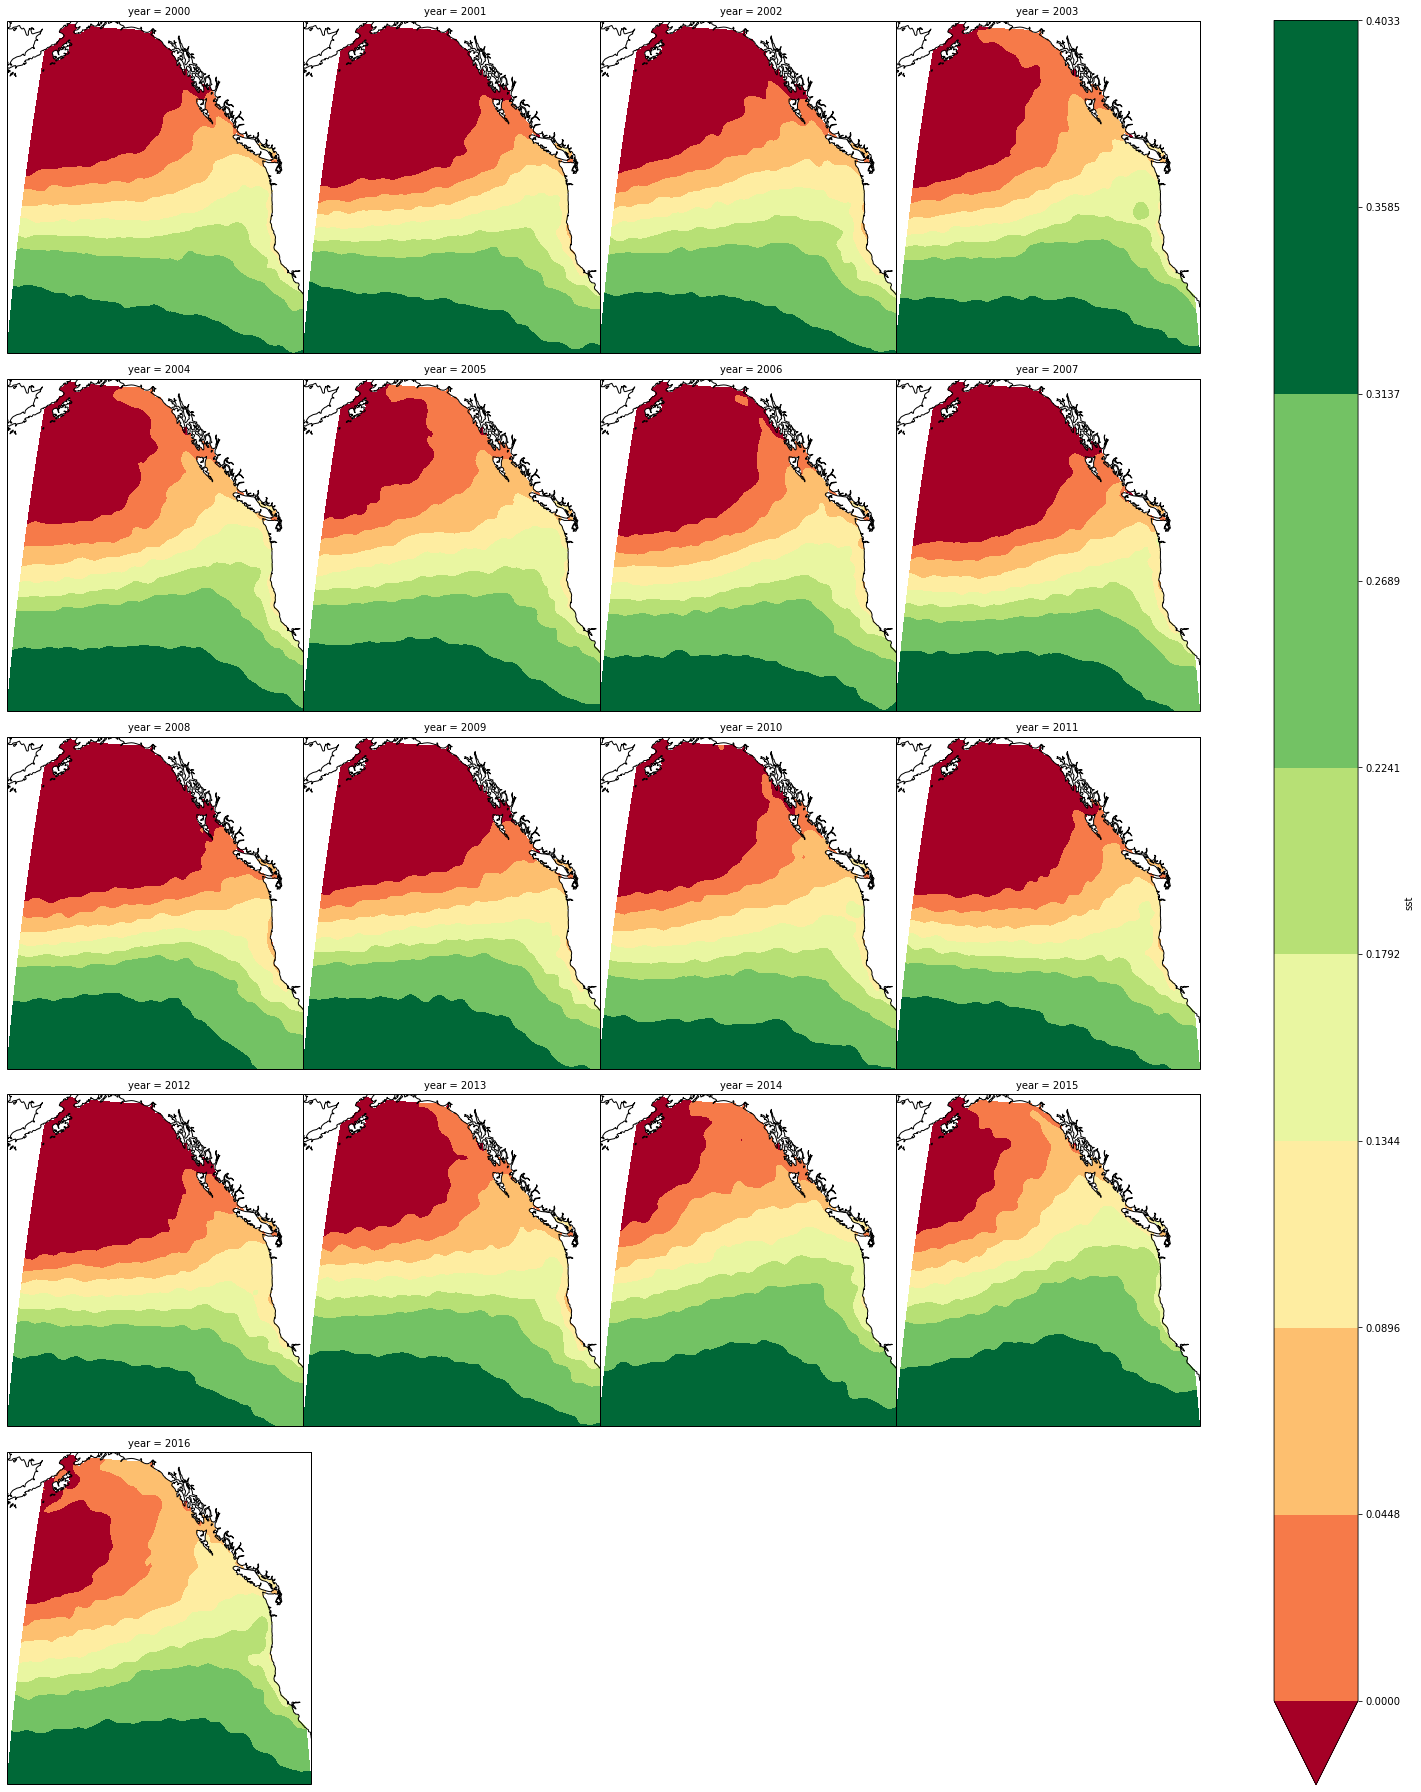

In [98]:
extent = [
    oisst_pnw.lon.min().values,
    oisst_pnw.lon.max().values,
    oisst_pnw.lat.min().values,
    oisst_pnw.lat.max().values

]

fg = ans.sel(time=slice('2000', '2016')).groupby('time.year').mean(dim='time').plot.contourf(
    size=5, levels=10, col='year', vmin=0, extend='min',
    col_wrap=4, cmap='RdYlGn',
    transform=ccrs.PlateCarree(), subplot_kws={'projection': PLOT_MAP_PROJECTION},
)

list(map(lambda x: x.set_extent(extent), fg.axes.ravel()))
list(map(lambda x: x.add_feature(cf.NaturalEarthFeature('physical', 'coastline', '50m'), facecolor='none', edgecolor='k'), fg.axes.ravel()))

The following figure presents the same data for **2015**, grouped by month. 

Text(0.5, 0.98, '2015')

<Figure size 432x288 with 0 Axes>

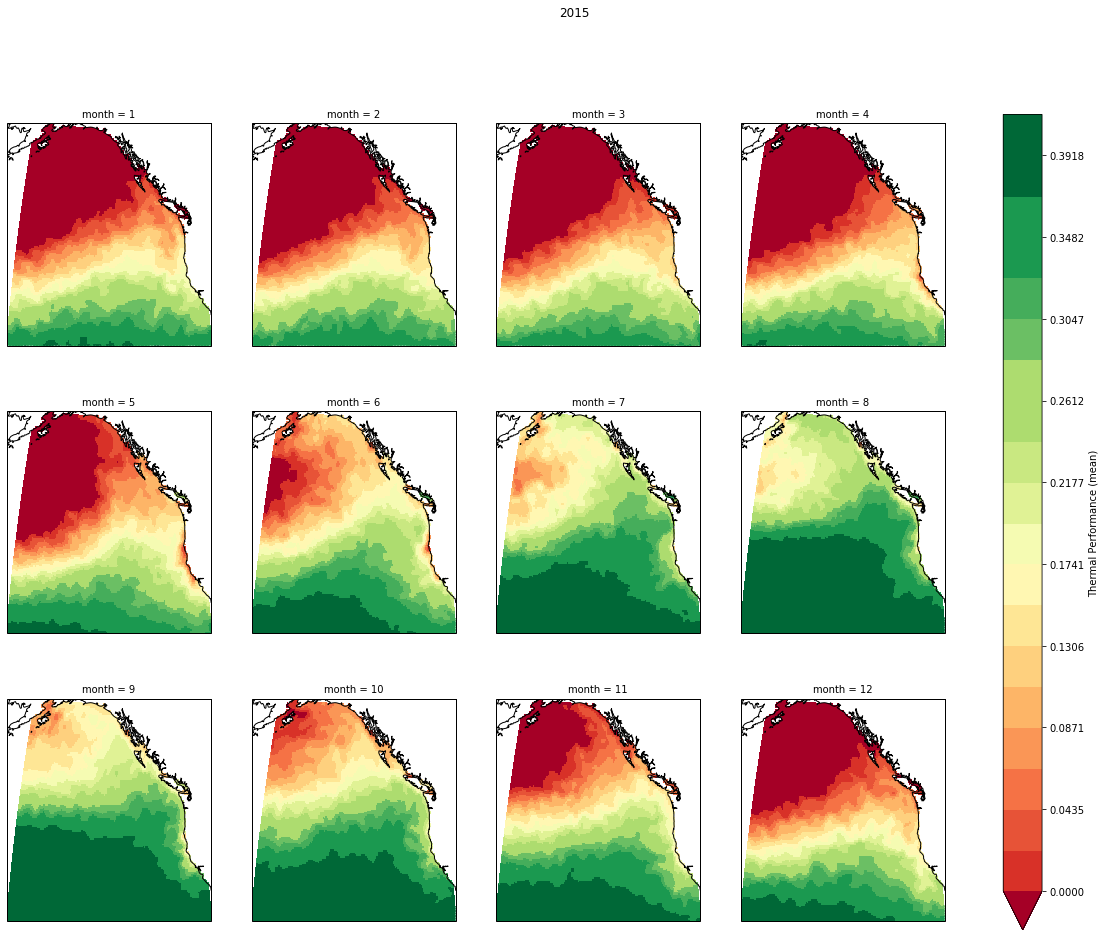

In [172]:
extent = [
    oisst_pnw.lon.min().values,
    oisst_pnw.lon.max().values,
    oisst_pnw.lat.min().values,
    oisst_pnw.lat.max().values

]
plt.figure()
fg = ans.sel(time='2015').groupby('time.month').mean(dim='time').plot.pcolormesh(
    size=5, levels=20, vmin=0, extend='min',
    col='month', col_wrap=4, cmap='RdYlGn', 
    transform=ccrs.PlateCarree(), subplot_kws={'projection': PLOT_MAP_PROJECTION},
)
list(map(lambda x: x.set_extent(extent), fg.axes.ravel()))
list(map(lambda x: x.add_feature(cf.NaturalEarthFeature('physical', 'coastline', '50m'), facecolor='none', edgecolor='k'), fg.axes.ravel()))
fg.cbar.set_label("Thermal Performance (mean)")
fg.fig.suptitle("2015")

## Peformance during "Normal" periods vs "SST" periods. 

We mask the SST data to contain only "MHW-containing" pixels or "non-MHW containing pixels." The resulting TPCs will be computed with the `NaN`s intact, allowing us to compare "MHW" state to "non-MHW" states with regard to computed performance. 

**The Purpose** of this analysis is to figure out whether there is a *difference* between MHW periods and non-MHW periods. The first approach we'll take here is to compare "MHW" SST pixels to "non-MHW" sst pixels. Potential issues: 
* There will be seasonal mismatch between pixels (e.g. heatwaves are likely to occur in Season X, which will invariably have different performance than All Other Times. FOr the above reason we will compare against climatology . 

We apply a MHW threshold of $\ge 45$ days and perform this analysis on a *latitudinal band* defined below.  

In [ ]:
DURATION_THRESHOLD = 45

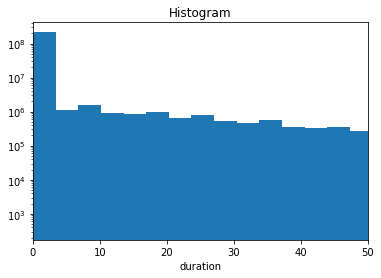

In [38]:
mhws.duration.plot(bins=100)
plt.xlim([0, 50])
plt.yscale('log')

In [25]:
mhw_only_filter = (mhws.mhw !=0) & (mhws.duration >= DURATION_THRESHOLD)
non_mhw_filter = ~(mhws.mhw.notnull())

In [26]:
mhw_only = oisst_pnw.isel(lat=slice(0, 10)).where(mhw_only_filter, drop=True)
non_mhw = oisst_pnw.isel(lat=slice(0,10)).where(~mhw_only_filter)

In [27]:
non_mhw

,Array,Chunk
Bytes,76.36 MB,2.00 MB
Shape,"(13636, 10, 140)","(500, 10, 100)"
Count,2471 Tasks,56 Chunks
Type,float32,numpy.ndarray


(732312.0, 733407.0)

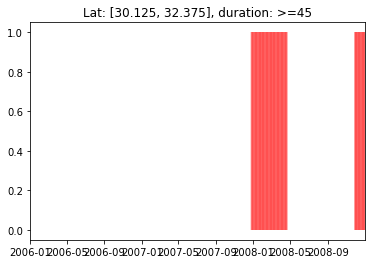

In [113]:
plt.vlines(mhw_only.time.values, ymin=0, ymax=1, color='red', alpha=0.2)
plt.title("Lat: [{}, {}], duration: >={}".format(mhw_only.lat.min().values, mhw_only.lat.max().values, 45))
plt.xlim(['2006-01-01', '2008-12-31'])

above plots verify that we're selecting only SST during MHWs as defined above

**We choose ONE LOCATION** for ease -- see below.

In [137]:
one_location = mhw_only.isel(lat=2, lon=10)
one_location = one_location.lon.values, one_location.lat.values

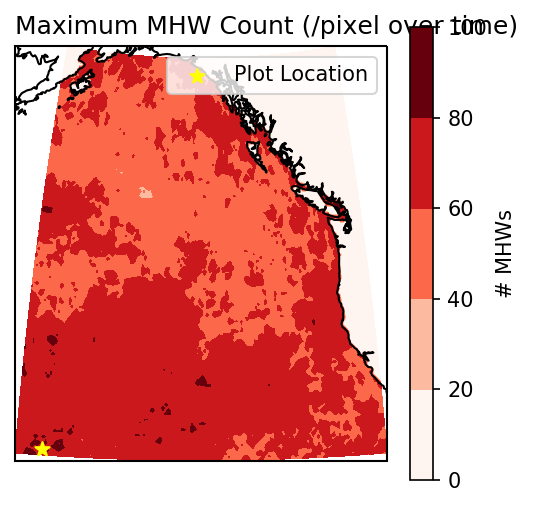

In [150]:
fig = plt.figure(figsize=(4,4), dpi=150)
ax = plt.axes(projection=PLOT_MAP_PROJECTION)
mhws.mhw.max(dim='time').plot.contourf(
    ax=ax, transform=ccrs.PlateCarree(),
    cbar_kwargs={'label' : "# MHWs"},
    cmap=plt.cm.Reds
)
ax.add_feature(cf.NaturalEarthFeature('physical', 'coastline', '50m'), facecolor='none', edgecolor='k')
ax.set_title("Maximum MHW Count (/pixel over time)", loc='left')
plt.scatter(one_location[0], one_location[1], color='yellow', marker='*', s=50, transform=ccrs.PlateCarree(), label='Plot Location')
plt.legend()
# ax.gridlines()

**Sanity Check** to observe whether we see separation of MHW and non-MHW data.

(731947.0, 733408.0)

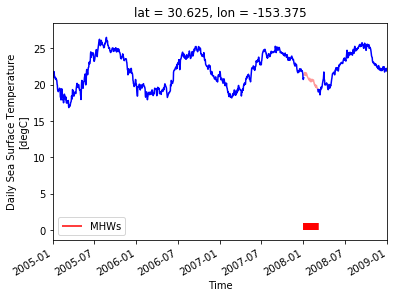

In [151]:
dat = mhw_only.isel(lat=2, lon=10)
dat.sst.plot(color='red',alpha=0.4)
non_mhw.sel(lat=dat.lat, lon=dat.lon).sst.plot(color='blue')
plt.vlines(dat.where(mhw_only_filter.sel(lat=dat.lat, lon=dat.lon), drop=True).time.values, ymin=0, ymax=1, color='red', label='MHWs')
plt.legend()
plt.xlim(['2005', '2009'])

ok, separation of mhw/non working.

Now we compare performance in MHW regions to non-mhw regions. 


In [28]:
tpc_mhws = xr.apply_ufunc(
    tpc_1d,
    mhw_only.sst.chunk({'lat': 5, 'lon': 5, 'time': -1}),
    input_core_dims=[['time']],
    output_core_dims = [['time']],
    dask='parallelized', 
    output_dtypes=['float64'],
    vectorize=True
)
tpc_non_mhw = xr.apply_ufunc(
    tpc_1d,
    non_mhw.sst.chunk({'lat': 5, 'lon': 5, 'time': -1}),
    input_core_dims=[['time']],
    output_core_dims = [['time']],
    dask='parallelized', 
    output_dtypes=['float64'],
    vectorize=True
)

In [30]:
tpc_mhws = tpc_mhws.compute()
tpc_non_mhw = tpc_non_mhw.compute()

/home/ec2-user/miniconda3/envs/notebook/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


(733773.0, 735599.0)

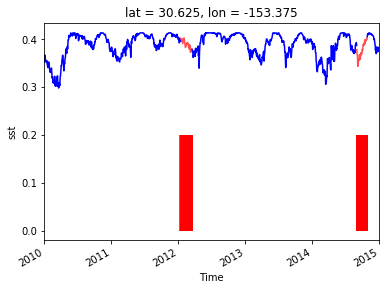

In [31]:
dat = tpc_mhws.isel(lat=2, lon=10)
dat.plot(color='red',alpha=0.7)
tpc_non_mhw.sel(lat=dat.lat, lon=dat.lon).plot(color='blue')
plt.vlines(dat.where(mhw_only_filter.sel(lat=dat.lat, lon=dat.lon), drop=True).time.values, ymin=0, ymax=0.2, color='red', label='MHWs')

plt.xlim(['2010', '2015'])

**This doesn't seem to be the approach.**

Here we'll pivot:

## Performance: MHW SST vs Climatology

In [32]:
tpc_sst = xr.apply_ufunc(
    tpc_1d,
    oisst_pnw.sst.chunk({'lat': 5, 'lon': 5, 'time': -1}),
    input_core_dims=[['time']],
    output_core_dims = [['time']],
    dask='parallelized', 
    output_dtypes=['float64'],
    vectorize=True
).compute()
tpc_climatology = xr.apply_ufunc(
    tpc_1d,
    mhws.clim_seas.chunk({'lat': 5, 'lon': 5, 'time': -1}),
    input_core_dims=[['time']],
    output_core_dims = [['time']],
    dask='parallelized', 
    output_dtypes=['float64'],
    vectorize=True
).compute()

We'll define this difference as the difference between performance @ SST and the performance at the climatology. 

**This means that whenever the metric is *Negative*, performance at actual SST is *less* than that at the climatological mean.**

In [33]:
tpc_clim_diff = tpc_sst - tpc_climatology

Here's a figure for the whole time period, averaged yearly: 

/home/ec2-user/miniconda3/envs/notebook/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


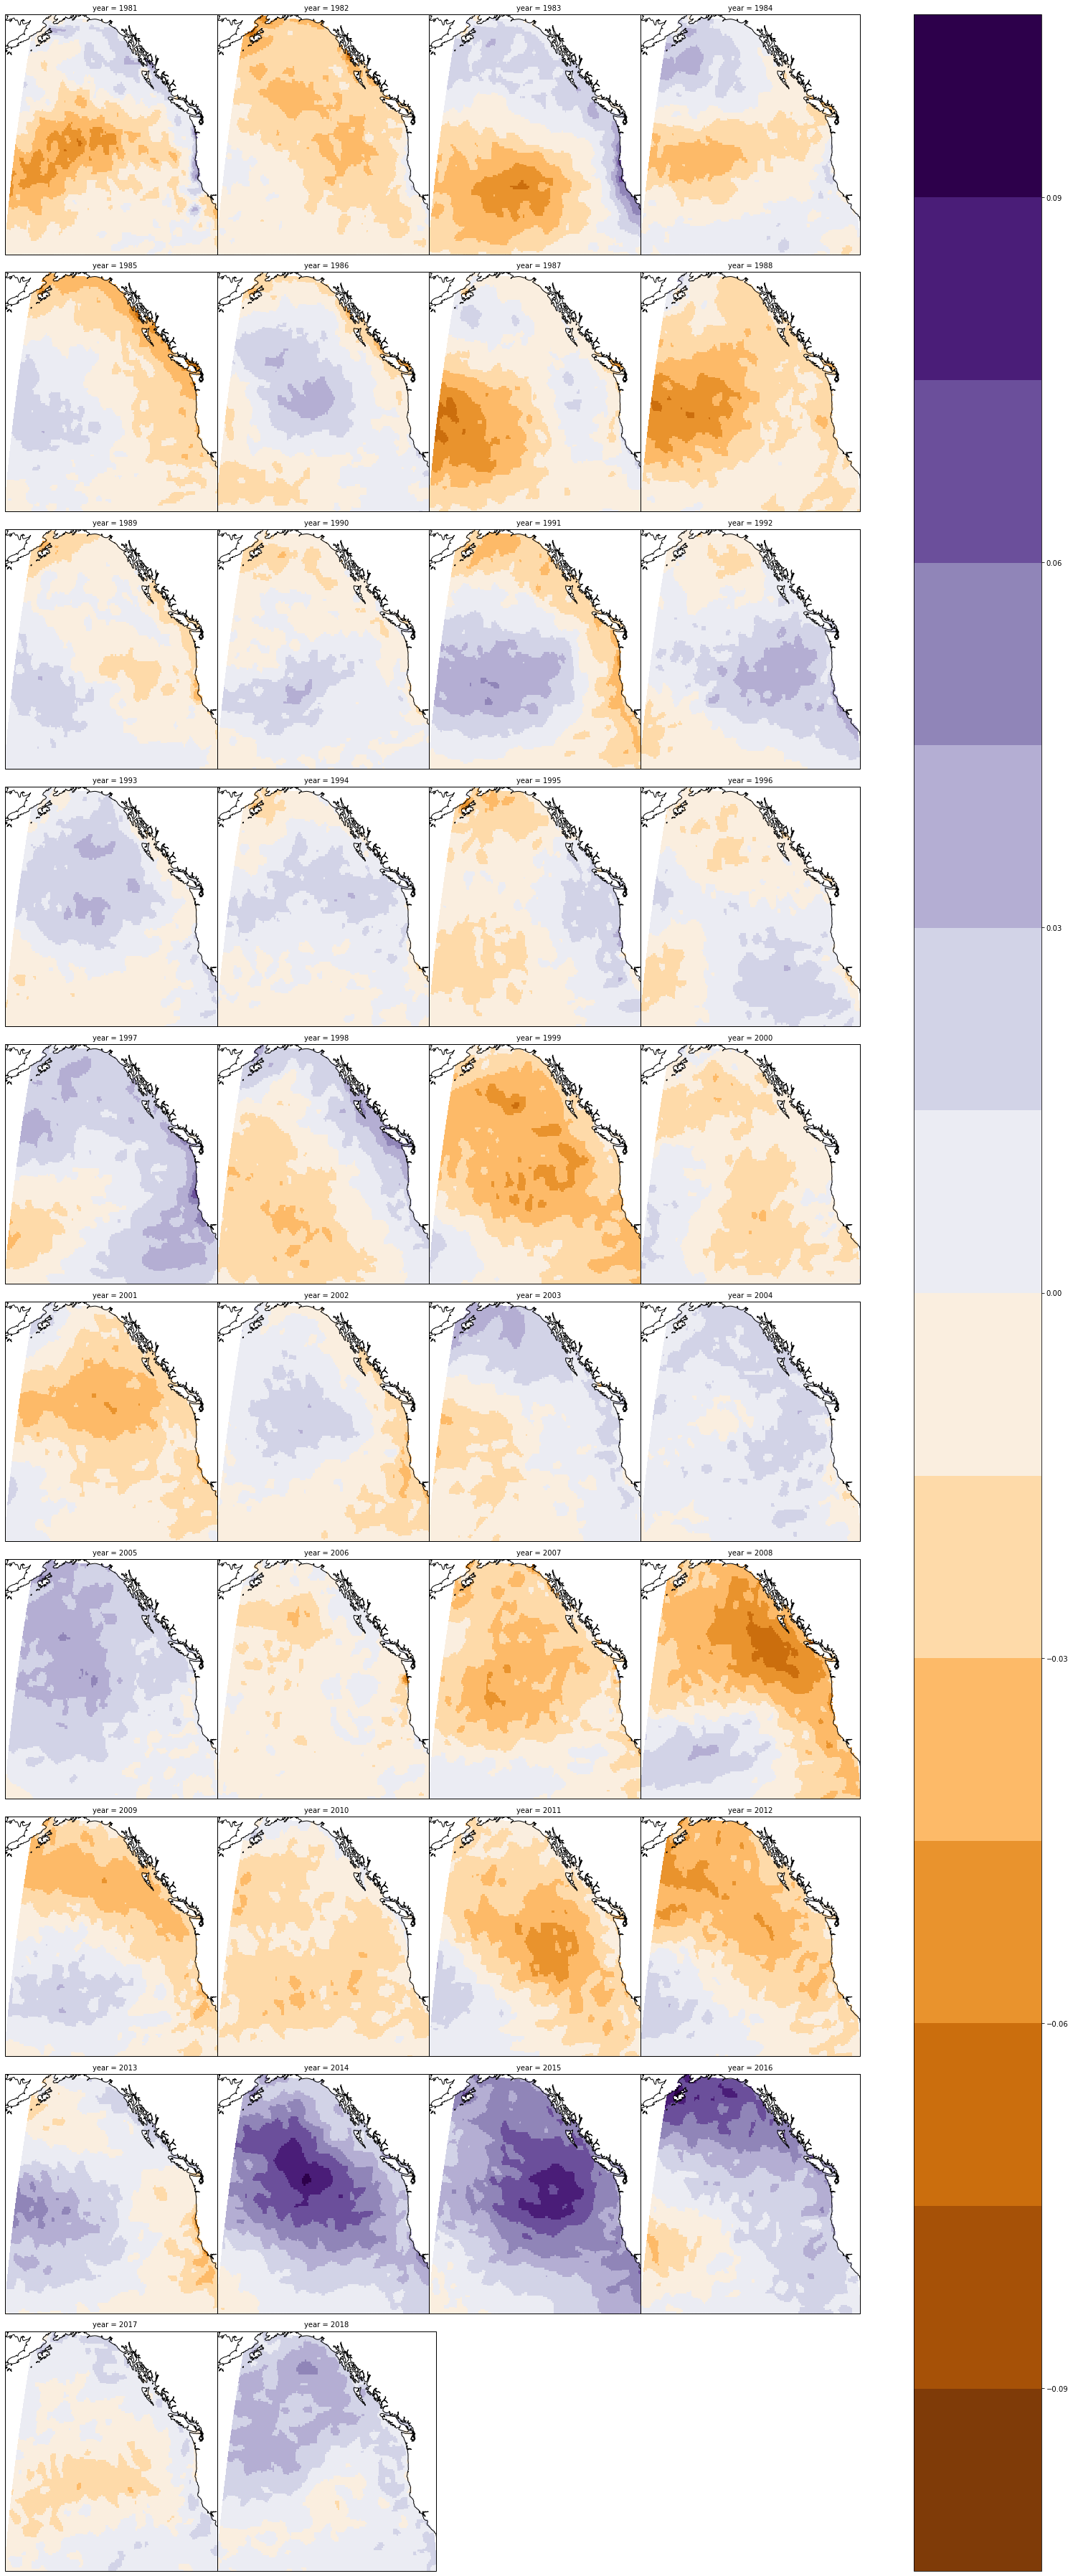

In [34]:
fg = tpc_clim_diff.groupby('time.year').mean(dim='time').plot.pcolormesh(size=5, levels=20, col='year', col_wrap=4, cmap='PuOr', transform=ccrs.PlateCarree(), subplot_kws={'projection': PLOT_MAP_PROJECTION}, )
list(map(lambda x: x.set_extent(extent), fg.axes.ravel()))
list(map(lambda x: x.add_feature(cf.NaturalEarthFeature('physical', 'coastline', '50m'), facecolor='none', edgecolor='k'), fg.axes.ravel()));

Here's a **single year** (2015).

Text(0.5, 0.98, '2015')

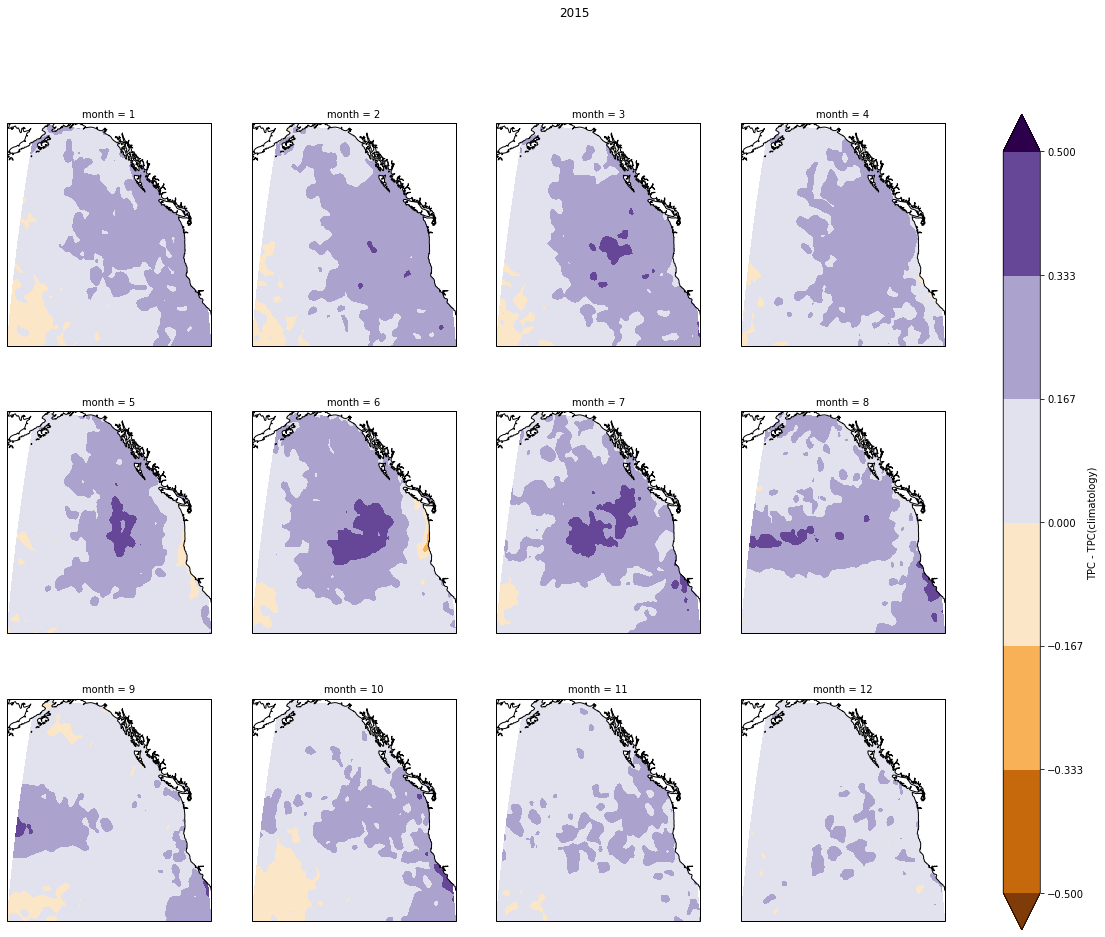

In [177]:
fg = tpc_clim_diff.sel(time='2015').groupby('time.month').mean(dim='time').plot.contourf(
    col='month', col_wrap=4, size=5, vmin=-0.5, vmax=0.5, extend='both',
    transform=ccrs.PlateCarree(), cmap='PuOr',
    subplot_kws={'projection': PLOT_MAP_PROJECTION},
    cbar_kws={'label': "TPC difference from TPC(climatology)"}
)
list(map(lambda x: x.set_extent(extent), fg.axes.ravel()))
list(map(lambda x: x.add_feature(cf.NaturalEarthFeature('physical', 'coastline', '50m'), facecolor='none', edgecolor='k'), fg.axes.ravel()))
fg.cbar.set_label("TPC - TPC(climatology)")

fg.fig.suptitle("2015")

And another ("non-mhw") year (2006)

/home/ec2-user/miniconda3/envs/notebook/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/ec2-user/miniconda3/envs/notebook/lib/python3.7/site-packages/xarray/plot/facetgrid.py:371: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


Text(0.5, 0.98, '2006')

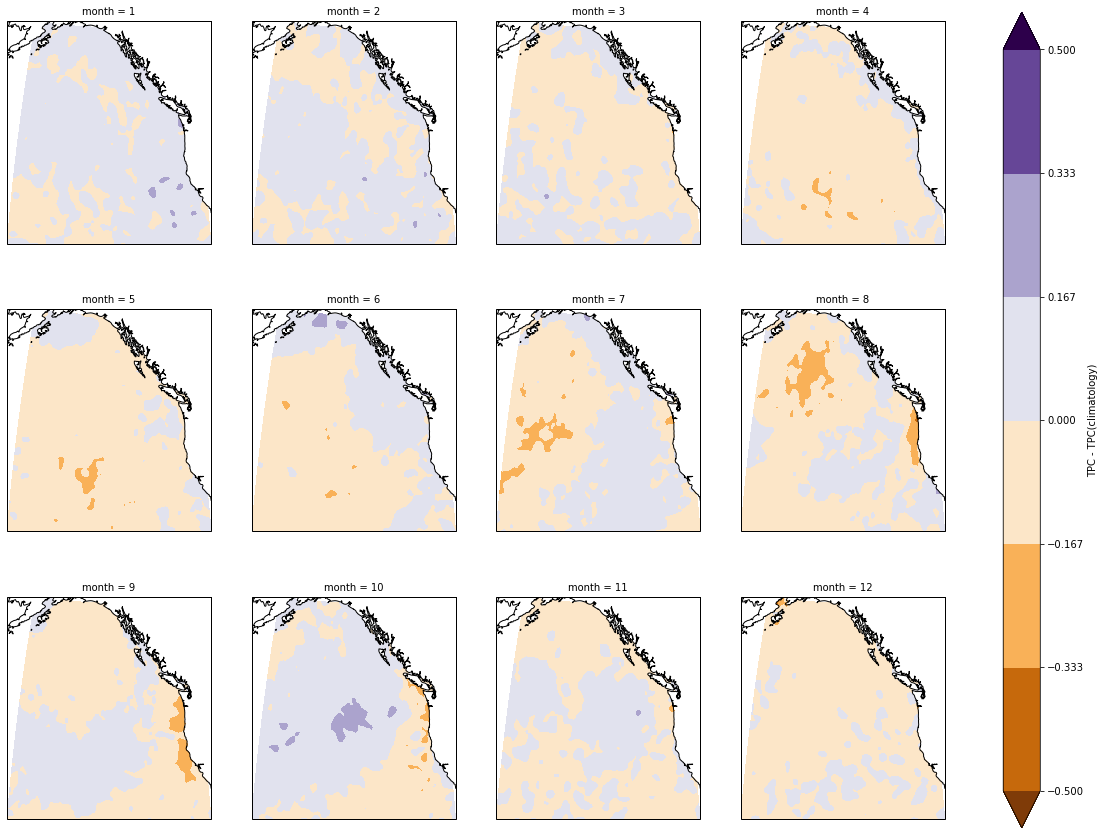

In [179]:
fg = tpc_clim_diff.sel(time='2006').groupby('time.month').mean(dim='time').plot.contourf(
    col='month', col_wrap=4, size=5, vmin=-0.5, vmax=0.5, extend='both',
    transform=ccrs.PlateCarree(), cmap='PuOr',
    subplot_kws={'projection': PLOT_MAP_PROJECTION},
)
list(map(lambda x: x.set_extent(extent), fg.axes.ravel()))
list(map(lambda x: x.add_feature(cf.NaturalEarthFeature('physical', 'coastline', '50m'), facecolor='none', edgecolor='k'), fg.axes.ravel()))
fg.cbar.set_label("TPC - TPC(climatology)")
fig.suptitle('2006')

In [214]:
fg.cbar.set_label("TPC - TPC(climatology)")

## Let's see if we can generalize this across all MHWs.

We'll start by doing this for a single location

In [35]:
tpc_clim_diff_onelocation = tpc_clim_diff.isel(lon=130, lat=9)
tpc_clim_diff_onelocation

<xarray.DataArray (time: 13636)>
array([-0.05629608, -0.06096083, -0.06110456, ...,  0.02634422,
        0.0315149 ,  0.02722852])
Coordinates:
    lat      float32 32.375
    lon      float32 -123.375
  * time     (time) datetime64[ns] 1981-09-01 1981-09-02 ... 2018-12-31

In [36]:
thisloc_mhws = mhws.where(mhw_only_filter).isel(lon=130, lat=9)
these_mhwtimes = thisloc_mhws.time.where(mhw_only_filter.isel(lon=130, lat=9), drop=True)

In [37]:
thisloc_mhws

<xarray.Dataset>
Dimensions:               (time: 13636)
Coordinates:
    lat                   float32 32.375
    lon                   float64 -123.4
  * time                  (time) datetime64[ns] 1981-09-01 ... 2018-12-31
Data variables:
    clim_seas             (time) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    clim_thresh           (time) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    duration              (time) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    index_end             (time) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    index_peak            (time) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    index_start           (time) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    intensity_cumulative  (time) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    intensity_max         (time) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    intensity_mean        (time) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    intensity_var         (time) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    mhw                   (time) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    rate_decline          (time) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    rate_onset            (time) float64 dask.array<chunksize=(500,), meta=np.ndarray>

In [191]:
these_mhw_events = list(zip(
    np.unique(thisloc_mhws.sel(time=these_mhwtimes).index_start.values),
    np.unique(thisloc_mhws.sel(time=these_mhwtimes).index_end.values)
))

In [201]:
for event in these_mhw_events:
    print(tpc_clim_diff.isel(time=slice(int(event[0]), int(event[1]))).sel(lon=thisloc_mhws.lon, lat=thisloc_mhws.lat).mean(dim='time'))


<xarray.DataArray ()>
array(0.04362366)
Coordinates:
    lat      float32 32.375
    lon      float32 -123.375
<xarray.DataArray ()>
array(0.05457006)
Coordinates:
    lat      float32 32.375
    lon      float32 -123.375
<xarray.DataArray ()>
array(0.06375598)
Coordinates:
    lat      float32 32.375
    lon      float32 -123.375
<xarray.DataArray ()>
array(0.05077702)
Coordinates:
    lat      float32 32.375
    lon      float32 -123.375


---

In [67]:
from rasterio import features, transform

In [110]:
mhws.lat.min()

<xarray.DataArray 'lat' ()>
array(30.125)

In [143]:
xf = transform.from_bounds(mhws.lon.min(), mhws.lat.max(), mhws.lon.max(), mhws.lat.min(), len(mhws.lon), len(mhws.lat))

In [147]:
mhws.lat.min()

<xarray.DataArray 'lat' ()>
array(30.125)

In [180]:
oneday = mhws.isel(time=12095)
binary_mhw =(oneday.where(mhw_only_filter.isel(time=12095)).mhw > 0)
transforms = [geometry.shape(_[0]) for _ in list(features.shapes(np.array(binary_mhw).astype('int16'), mask=np.array(binary_mhw), transform=xf))]

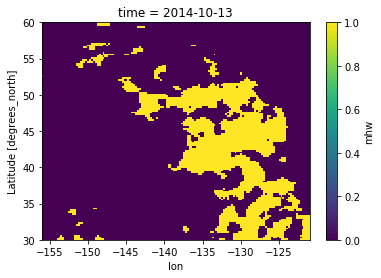

In [181]:
binary_mhw.plot()

In [134]:
mhws.lon.min()

<xarray.DataArray 'lon' ()>
array(-155.875)

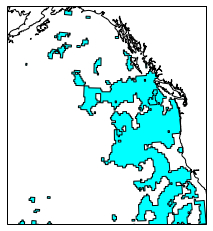

In [182]:
ax = plt.axes(projection = PLOT_MAP_PROJECTION)
ax.set_extent(extent)
ax.add_geometries(transforms, crs=ccrs.PlateCarree(), facecolor='xkcd:cyan', edgecolor='black')
ax.add_feature(cf.NaturalEarthFeature('physical', 'coastline', '50m'), facecolor='none', edgecolor='k')

In [61]:
np.array((oneday.mhw > 0).astype('int'))

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [149]:
import geopandas as gpd

In [183]:
gpd.GeoDataFrame(geometry=transforms).to_file("tester.geojson", driver='GeoJSON')